## Sentiment analysis on Amazon reviews using Spacy

In [12]:
import pandas as pd
import spacy
import random
import matplotlib.pyplot  as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from spacy.util import minibatch, compounding


In [17]:
nlp=spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

In [18]:
textcat=nlp.create_pipe( "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [19]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

### Load amazon reviews scraped using Scrapy tool 

In [20]:
df = pd.read_csv("reviews2.csv")
df.head()

,stars,comment
0,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n The phone ...
1,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Not good w...
2,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This phone...
3,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Pathetic A...
4,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n I found th...


### Visualizing the data (notice the class imbalance) 

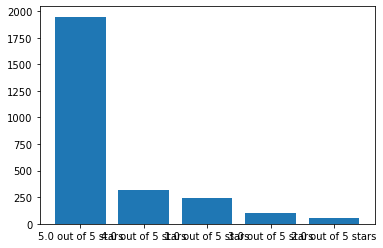

In [21]:
summarised_results = df["stars"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.show()

### Make the data binary classification problem 

In [22]:

print(df['stars'].value_counts())
df.loc[(df.stars == '1.0 out of 5 stars') , 'stars'] = 0
df.loc[(df.stars == '2.0 out of 5 stars') , 'stars'] = 0
df.loc[(df.stars == '3.0 out of 5 stars' ), 'stars' ]=1
df.loc[(df.stars == '4.0 out of 5 stars' ), 'stars' ]=1
df.loc[(df.stars == '5.0 out of 5 stars' ), 'stars' ]=1
df['stars'].value_counts()

5.0 out of 5 stars    1947
4.0 out of 5 stars     322
1.0 out of 5 stars     244
3.0 out of 5 stars     106
2.0 out of 5 stars      51
Name: stars, dtype: int64


1    2375
0     295
Name: stars, dtype: int64

### Solving class imbalance problem using downsampling 

In [23]:
df_majority = df[df.stars==1]
df_minority = df[df.stars==0]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=300,     
                                 random_state=123) 
 

df = pd.concat([df_majority_downsampled, df_minority])
 

df.stars.value_counts()

1    300
0    295
Name: stars, dtype: int64

### Data after downsampling and binary classification 

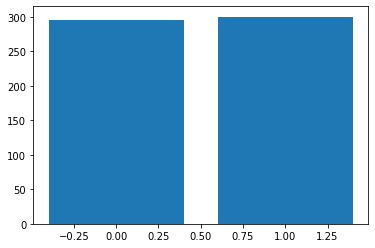

In [24]:
summarised_results = df["stars"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.show()

In [25]:
df['tuples'] = df.apply(lambda row: (row['comment'],row['stars']), axis=1)
train =df['tuples'].tolist()

### Split dataset into train and test 

In [26]:
def load_data(limit=0, split=0.8):
    train_data=train
    # Shuffle the data
    #random.shuffle(train_data)
    texts, labels = zip(*train_data)
    # get the categories for each review
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    # Splitting the training and evaluation data
    #split = int(len(train_data) * split)
    #return (texts[:split], cats[:split]), (texts[split:], cats[split:])
    X_train, X_test, y_train, y_test  = train_test_split(texts, cats, test_size=1-split, random_state=42)
    return (X_train,y_train ), (X_test, y_test )

n_texts=595

# Calling the load_data() function 
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)

# Processing the final format of training data
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))

#print(train_cats)
p = 0
n=0
for i in range (len(train_cats)):
    if train_cats[i]['POSITIVE'] == True:
        p+=1
    else:
        n+=1
print("# of examples in train dataset: ", len(train_cats))
print("# of positive examples in train dataset: ", p, p*100/len(train_cats))
print("# of negative examples in train dataset: ", n, n*100/len(train_cats))
p = 0
n=0
for i in range (len(dev_cats)):
    if dev_cats[i]['POSITIVE'] == True:
        p+=1
    else:
        n+=1
print("# of examples in test dataset: ", len(dev_cats))
print("# of positive examples in test dataset: ", p, p*100/len(dev_cats))
print("# of negative examples in test dataset: ", n, n*100/len(dev_cats))


# of examples in train dataset:  476
# of positive examples in train dataset:  231 48.529411764705884
# of negative examples in train dataset:  245 51.470588235294116
# of examples in test dataset:  119
# of positive examples in test dataset:  69 57.983193277310924
# of negative examples in test dataset:  50 42.016806722689076


In [27]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


#("Number of training iterations", "n", int))
n_iter=10

### Training model using Spacy 

In [28]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))

    # Performing training
    for i in range(n_iter):
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)

      # Calling the evaluate() function and printing the scores
        with textcat.model.use_params(optimizer.averages):
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
2.938	0.912	0.754	0.825
1.326	0.869	0.768	0.815
0.540	0.885	0.783	0.831
0.264	0.885	0.783	0.831
0.236	0.879	0.841	0.859
0.194	0.881	0.855	0.868
0.164	0.873	0.797	0.833
0.081	0.873	0.797	0.833
0.200	0.817	0.841	0.829
0.096	0.889	0.812	0.848


### Testing with a review 

In [29]:
test_text="This phone is terrible"
doc=nlp(test_text)
doc.cats 

{'POSITIVE': 8.116952110448494e-10, 'NEGATIVE': 1.0}